In [14]:
import jax
import jax.numpy as jnp
print(jax.devices())
print(jnp.sin(jnp.pi/2))

[CpuDevice(id=0)]
1.0


In [15]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib
import matplotlib.pyplot as plt
from functools import partial
import time

In [16]:
jax.devices()

[CpuDevice(id=0)]

In [10]:
# Run JAX with 64 bit precision.
# jax.config.update("jax_enable_x64", True)

$$
\begin{align}
&N = 10^4\\
&N_{\text{valid}} = N_{\text{test}} = 10^3\\
&d = 4\\
&a = 10^{-2}\\
&x_1,...,x_d \sim \mathcal{N}(0,1)\\
&y = f(x)\\
&f(x) = \text{sinint}(\frac{x_0}{a})e^{-\frac{||x||^2_2}{2}}
\end{align}
$$

In [11]:
data_path = 'data/reg_disc_4d_1_discontinuity_N10_000/'

In [12]:
with open(data_path + 'x_pts.npy', 'rb') as fs:
    x_pts = jnp.load(fs)
with open(data_path + 'y_pts.npy', 'rb') as fs:
    y_pts = jnp.load(fs)
with open(data_path + 'x_test.npy', 'rb') as fs:
    x_test = jnp.load(fs)
with open(data_path + 'y_test.npy', 'rb') as fs:
    y_test = jnp.load(fs)
with open(data_path + 'x_val.npy', 'rb') as fs:
    x_valid = jnp.load(fs)
with open(data_path + 'y_val.npy', 'rb') as fs:
    y_valid = jnp.load(fs)
with open(data_path + 'x_means.npy', 'rb') as fs:
    x_means = jnp.load(fs)
with open(data_path + 'x_stds.npy', 'rb') as fs:
    x_stds = jnp.load(fs)
with open(data_path + 'y_means.npy', 'rb') as fs:
    y_means = jnp.load(fs)
with open(data_path + 'y_stds.npy', 'rb') as fs:
    y_stds = jnp.load(fs)

print(x_pts.shape)
print(y_pts.shape)

(10000, 4)
(10000,)


In [13]:
@jax.jit
def get_S(x, omega):
    omega_x = jnp.matmul(x, omega)
    sv = jnp.hstack([jnp.cos(omega_x), jnp.sin(omega_x)])
    return sv

In [8]:
@jax.jit
def get_c(x, y, lambda_reg, omega):
    N = x.shape[0]
    S = get_S(x, omega)
    Ss = jnp.transpose(S)

    def S_operator(p):
        #(S^*S + N\lambdaI)p = S^*(Sp) + N\lambdap
        return jnp.matmul(Ss, jnp.matmul(S, p)) + N * lambda_reg * p

    return jax.scipy.sparse.linalg.cg(S_operator, jnp.matmul(Ss, y))[0]

$$
\begin{align}
&\text{Neural network: }\beta(x) = \sum_{k=1}^{K} \left(\hat{\beta}_k\cos(\omega_k\cdot x) + \check{\beta}_k\sin(\omega_k\cdot x)\right)\\
&\text{Resampling step: }\frac{||(\hat{\beta}_k, \check{\beta}_k)||_2}{\sum_{k'}^K||(\hat{\beta}_{k'}, \check{\beta}_{k'})||_2}
\end{align}
$$

In [9]:
vnorm = jax.vmap(jnp.linalg.norm, in_axes=(1,))

In [10]:
@jax.jit
def mse(x, y, params, N):
    St = get_S(x, params["omega"])
    beta = jnp.matmul(St, params["c"])
    return jnp.sum((beta - y)**2)/N

In [11]:
@partial(jax.jit, static_argnames=['RESAMPLING', 'DO_METROPOLIS_TEST'])
def arff_one_step(key, params, x_pts, y_pts, delta, lambda_reg, gamma, N, N_valid, N_test,
                RESAMPLING=True, DO_METROPOLIS_TEST=True):
    c = params["c"]
    omega = params["omega"]

    cn = vnorm(jnp.reshape(c, (2, omega.shape[1])))
    
    if RESAMPLING:
        amp_pmf = cn / jnp.sum(cn)
        key, subkey = random.split(key)
        omega = omega[:, random.choice(subkey, cn.__len__(), shape=(omega.shape[1],), p=amp_pmf)]
        if DO_METROPOLIS_TEST:
            c = get_c(x_pts, y_pts, lambda_reg, omega)

    if DO_METROPOLIS_TEST:
        key, subkey = random.split(key)
        dw = random.normal(subkey, omega.shape)
        omega_prime = omega + delta * dw

        cn_prime = vnorm(jnp.reshape(get_c(x_pts, y_pts, lambda_reg, omega_prime), (2, omega.shape[1])))

        key, subkey = random.split(key)
        omega = jnp.where((cn_prime / cn) ** gamma >= random.uniform(subkey, omega.shape[1]), omega_prime, omega)
           
    else:
        key, subkey = random.split(key)
        dw = random.normal(subkey, omega.shape)
        omega = omega + delta * dw

    c = get_c(x_pts, y_pts, lambda_reg, omega)

    return {"omega" : omega, "c" : c}, key

In [12]:
N = x_pts.shape[0]
N_test = x_test.shape[0]
N_valid = x_valid.shape[0]
batch_size = jnp.minimum(10**4, N)
d = x_pts.shape[1]

K = int(1.5*N)
SEED = 2357

key = random.PRNGKey(SEED)

# AM/resampling
lambda_reg = (10**(-1))/10
delta = 1/4
num_iter = 400
gamma = 3 * d - 2

start_time = time.time()


RESAMPLING = True
DO_METROPOLIS_TEST = False

validation_error = []
training_error = []
test_error = []
times = []

    
omega = jnp.zeros((d, K))
c = get_c(x_pts, y_pts, lambda_reg, omega)

params = {"omega" : omega, "c" : c}


for i in range(0, num_iter):
    params, key = arff_one_step(key, params, x_pts, y_pts, delta, lambda_reg, gamma, N, N_valid, N_test, RESAMPLING, DO_METROPOLIS_TEST)
    validation_error.append(mse(x_valid, y_valid, params, N_valid))
    training_error.append(mse(x_pts, y_pts, params, N))
    times.append(time.time() - start_time)
    
print('Time (s): ', time.time() - start_time)

Time (s):  1753.1982657909393


In [13]:
mse(x_test, y_test, params, N_valid)

Array(0.00010803, dtype=float32)

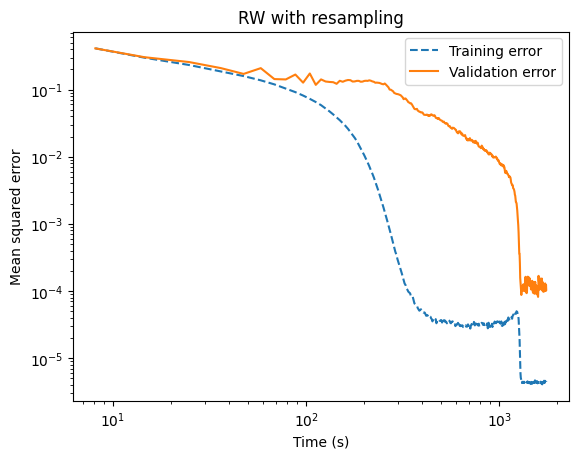

In [14]:
fig = plt.figure()
plt.loglog(times, training_error, '--', label='Training error')
plt.loglog(times, validation_error, '-', label='Validation error')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Mean squared error')
plt.title('RW with resampling')
plt.show()

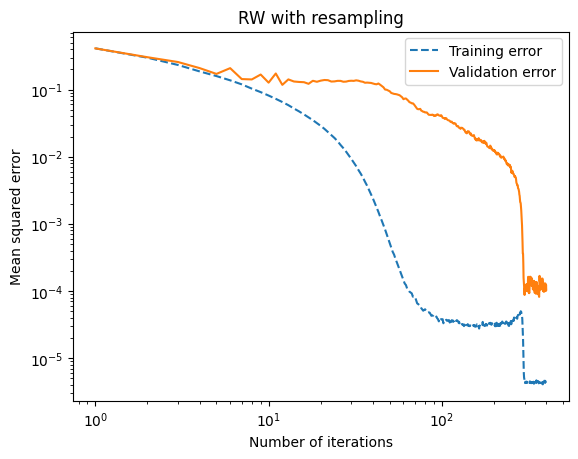

In [15]:
fig = plt.figure()
plt.loglog(jnp.array([x for x in range(1,num_iter+1)]), training_error, '--', label='Training error')
plt.loglog(jnp.array([x for x in range(1,num_iter+1)]), validation_error, '-', label='Validation error')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Mean squared error')
plt.title('RW with resampling')
plt.show()